# Unsupervised anomaly detection (NY property fraud) 

This notebook looks for anomalies in a dataset. We first do some data cleaning (exclusions, imputation) without removing outliers as that's what we're looking for, then build variables that are designed to look for the kinds of anomalies we are interested in, in this case, unusual property valuations.

After we build the variables we know we have lots of correlations and too high dimensionality so we need to remove correlations and reduce dimensionality. Since we don't have a dependent variable the easiest useful thing to do is PCA. We z scale, do PCA, keep the top few PCs, then z scale again in order to make each retained PC equally important.

We use two different anomaly detection (fraud) algorithms. The first just looks for outliers in the final scaled PC space using a Minkowski distance from the origin. The second method makes a simple autoencoder and the fraud score is then the reproduction error. It's important to note that each/either of these two methods can be used by itself.

Since we have two score and we don't really know which one is better we just average the two scores. To do this we replace the score with its rank order and then average the rank-ordered scores for our final score.

Finally we sort all the records by this final score and explore the top n records. To help the investigation we show which of the variables are driving these top scoring records with a heat map of the variable zscores, which can point the investigators to what's making the high score for these top scoring records.

The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [1]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 1.36 s, sys: 203 ms, total: 1.56 s
Wall time: 1.58 s


(1070994, 32)

In [3]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [4]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some properties that we aren't interested in

In [5]:
numrecords_orig = len(data)
numrecords = numrecords_orig
numrecords

1070994

In [6]:
#remove the records with easement type as goverment 
data = data[data["EASEMENT"] != "U"].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 1


In [7]:
# create some words for the owner name that might be goverment or a cemetery
gov_list = ['DEPT ', 'DEPARTMENT', 'UNITED STATES','GOVERNMENT',' GOVT ', 'CEMETERY']
owner1 = list(set(data['OWNER'].to_list()))
owner = (item for item in owner1 if str(item) != 'nan') #remove any nan's
remove_list = []
# print("Total owner number before removing is ", len(owner))

for i in owner:
   for g in gov_list:
    if g in i and 'STORES' not in i:
        remove_list.append(i)

In [8]:
type(owner)

generator

In [9]:
len(remove_list)

230

In [10]:
remove_list #check all the name here and edit if it is not a goverment name 

['U S GOVT NAVY',
 'UNITED STATES A-VA',
 'UNITED STATES A- VA',
 'U.S. DEPARTMENT OF H.',
 'NYC DEPT OF REAL ESTA',
 'THE UNITED STATES POS',
 'GOVERNMENT OF THE PEO',
 'UNITED STATES A OF VA',
 'US DEPARTMENT OF TRAN',
 'NYC DEPT WATER RESOUR',
 'UNITED STATES FUND FO',
 'DEPT PUBLIC WORKS N Y',
 'UNITED STATES A HUD',
 'NYC-DEPT OF HIGHWAYS',
 'DEPARTMENT OF CORRECT',
 'PELHAM CEMETERY ASSOC',
 'UNITED STATES POSTLSR',
 'U S GOVT VET ADMIN',
 'NYS DEPT OF TRANSPORT',
 'GOVERNMENT REPUBLICTO',
 'NYC DEPT ENVIRON PROT',
 'GOVERNMENT OF THE UNI',
 'UNITED STATES/AMERICA',
 'DEPARTMENT OF MENTAL',
 'NYC DEPT HWYS',
 'GOVERNMENT FED REP BR',
 'THE GOVERNMENT OF COT',
 'DEPT OF VETERAN AFFAI',
 'GOVERNMENT OF MEXICO',
 'MT ZION CEMETERY',
 'GOVERNMENT/REPBLC/NGR',
 'NYC DEPT OF R E',
 'NYC DEPT OF HWYS',
 'GOVERNMENT OF THE RUS',
 'WOODLAWN CEMETERY',
 'NYC - DEPT OF HIGHWAY',
 'GOVERNMENT OF THE GRA',
 'LAW DEPARTMENT',
 'HUNGARIAN GOVERNMENT',
 'KNOLLWOOD PK CEMETERY',
 'UNITED STATES P

In [11]:
# Look at the most frequent owners. This might show some other properties we aren't interested in.
remove_list2 = data['OWNER'].value_counts().head(20).index.tolist()
remove_list2

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [12]:
# add some others to also be removed
remove_list2.append('THE CITY OF NEW YORK')
remove_list2.append('NYS URBAN DEVELOPMENT')
remove_list2.append('CULTURAL AFFAIRS')
remove_list2.append('NY STATE PUBLIC WORKS')
remove_list2.append("NYC DEP'T OF HIGHWAYS")
remove_list2.append('CITY WIDE ADMINISTRAT')
remove_list2.append('NEW YORK CITY')
remove_list2.append('THE PORT OFNY & NJ')
remove_list2.append('NEW YORK STATE DEPART')
remove_list2.append('CITY AND NON-CITY OWN')
remove_list2.append('SANITATION')
remove_list2.append('NYS DOT')
remove_list2.append('NEW YORK CITY TRANSIT')
remove_list2.append('PORT AUTHORITY OF NY')
remove_list2.append('NEW YORK STATE OWNED')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('PORT OF NEW YORK AUTH')
remove_list2.append('NYC PARK DEPT')
remove_list2.append('LIRR')
remove_list2.append('NY STATE PUBLIC SERV')
remove_list2.append('STATE OF NEW YORK')
remove_list2.append('NYC HIGHWAY DEPT')

In [13]:
for i in remove_list2:
    if i not in remove_list:
        remove_list.append(i)
    else:
        print(i)

DEPT OF ENVIRONMENTAL
DEPARTMENT OF BUSINES
DEPT OF TRANSPORTATIO
NYC PARK DEPT


In [14]:
# rremove some of the removes...
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.remove('MH RESIDENTIAL 1, LLC')

In [15]:
len(remove_list)

263

In [16]:
numrecords = len(data)
removed = data[data['OWNER'].isin(remove_list)].reset_index(drop=True)
data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
numremoved = numrecords - len(data)
print('# records removed:', numremoved)

# records removed: 26500


In [17]:
removed.shape

(26500, 32)

<AxesSubplot: >

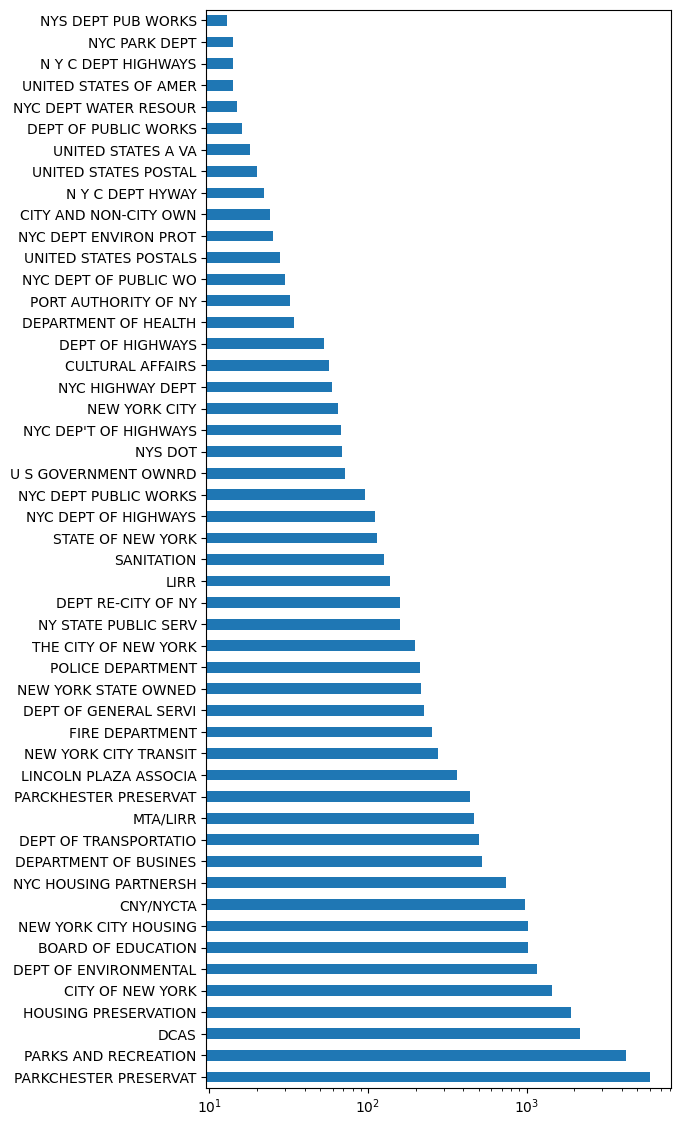

In [18]:
# any on this list that we shouldn't remove?
# plt.rcParams.update({'figure.figsize':(6,14)})
plt.figure(figsize=(6,14))
plt.xscale('log')
removed['OWNER'].value_counts().head(50).plot(kind='barh')

In [19]:
data.shape

(1044493, 32)

In [20]:
# this is how many records we removed
numrecords_orig - len(data)

26501

In [21]:
data.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
5,14,1000041006,1,4,1006,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,353383.0,1138493.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
6,15,1000041007,1,4,1007,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1246572.0,4016063.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
7,16,1000041008,1,4,1008,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
8,17,1000041009,1,4,1009,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
9,18,1000041010,1,4,1010,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,0,0,1213369.0,3909089.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


## Fill in missing ZIP

In [22]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
num_missing_zips_orig = len(missing_zips)
num_missing_zips_orig

20431

In [23]:
sum(data['BORO'].isna())

0

In [24]:
sum(data['STADDR'].isna())

364

In [25]:
# concatenate the 'staddr' and 'boro' columns into a new 'staddr_boro' column 
data['staddr_boro'] = data[data['STADDR'].notnull()]['STADDR'] + '_' + data[data['BORO'].notnull()]['BORO'].astype(str)
data['staddr_boro']

0              1 WATER STREET_1
1              1 WATER STREET_1
2              1 WATER STREET_1
3              1 WATER STREET_1
4              1 WATER STREET_1
                   ...         
1044488    142 BENTLEY STREET_5
1044489    146 BENTLEY STREET_5
1044490    150 BENTLEY STREET_5
1044491    156 BENTLEY STREET_5
1044492    162 BENTLEY STREET_5
Name: staddr_boro, Length: 1044493, dtype: object

In [26]:
staddr_boro_zip = {}
for index, staddrboro in data['staddr_boro'].items():
    if staddrboro not in staddr_boro_zip :
        staddr_boro_zip [staddrboro] = data.loc[index, 'ZIP']
        
        
# fill in by mapping with street addrees boroughs
data['ZIP'] = data['ZIP'].fillna(data['staddr_boro'].map(staddr_boro_zip))

In [27]:
# how many missing zips were filled in with this last step?
num_filled_in = num_missing_zips_orig - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

2832

In [28]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

17599

In [29]:
%%time
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(data.loc[missing_zips[i]+1,'ZIP'] == data.loc[missing_zips[i]-1,'ZIP']):
        data.loc[missing_zips[i],'ZIP'] = data.loc[missing_zips[i]-1,'ZIP']

CPU times: user 537 ms, sys: 3.92 ms, total: 540 ms
Wall time: 540 ms


In [30]:
# how many missing zips were filled in with this last step?
num_filled_in = len(missing_zips) - len(np.where(pd.isnull(data['ZIP']))[0])
num_filled_in

9491

In [31]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

8108

In [32]:
%%time
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    data.loc[missing_zips[i],'ZIP'] = data.loc[missing_zips[i]-1,'ZIP']

CPU times: user 337 ms, sys: 2.78 ms, total: 340 ms
Wall time: 340 ms


In [33]:
missing_zips = np.where(pd.isnull(data['ZIP']))[0]
len(missing_zips)

0

In [34]:
data = data.drop('staddr_boro', axis=1)

### FULLVAL, AVLAND, AVTOT

#### FULLVAL

In [35]:
len(data[data['FULLVAL']==0])

10025

In [36]:
data['FULLVAL'].isnull().sum()

0

In [37]:
data['FULLVAL'].replace(0, np.nan, inplace=True)
data['FULLVAL'].isnull().sum()

10025

In [38]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

7307

In [39]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS','BORO'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

386

In [40]:
data["FULLVAL"] = data.\
                        groupby(['TAXCLASS'])['FULLVAL'].transform(lambda x: x.fillna(x.mean()))
data['FULLVAL'].isnull().sum()

0

#### AVLAND

In [41]:
len(data[data['AVLAND']==0])

10027

In [42]:
data['AVLAND'].isnull().sum()

0

In [43]:
data['AVLAND'].replace(0, np.nan, inplace=True)
data['AVLAND'].isnull().sum()

10027

In [44]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

7307

In [45]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

386

In [46]:
data["AVLAND"] = data.\
                        groupby(['TAXCLASS'])['AVLAND'].transform(lambda x: x.fillna(x.mean()))
data['AVLAND'].isnull().sum()

0

#### AVTOT

In [47]:
len(data[data['AVTOT']==0])

10025

In [48]:
data['AVTOT'].isnull().sum()

0

In [49]:
data['AVTOT'].replace(0, np.nan, inplace=True)
data['AVTOT'].isnull().sum()

10025

In [50]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

7307

In [51]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS','BORO'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

386

In [52]:
data["AVTOT"] = data.\
                        groupby(['TAXCLASS'])['AVTOT'].transform(lambda x: x.fillna(x.mean()))
data['AVTOT'].isnull().sum()

0

In [53]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in the missing STORIES

In [54]:
data['STORIES'].isnull().sum()

42030

In [55]:
modes = data.groupby(['BORO', 'BLDGCL'])['STORIES'] \
         .transform(lambda x: x.mode(dropna=False).iloc[0])
data['STORIES'] = data['STORIES'].fillna(modes)

In [56]:
data['STORIES'].isnull().sum()

37922

In [57]:
data["STORIES"] = data.\
                        groupby(['TAXCLASS'])['STORIES'].transform(lambda x: x.fillna(x.mean()))

In [58]:
data['STORIES'].isnull().sum()

0

In [59]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [60]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# zero and 1 are invalid values for these fields, so replace them with NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
# Not sure which values to treat as missing. here are some choices.
data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
# data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
# data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
# data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
# data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
# data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
# data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

In [61]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,636093.0,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,919276.0,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
2,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,967500.0,5483912.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
3,12,1000041004,1,4,1004,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,163174.0,525692.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR
4,13,1000041005,1,4,1005,NaN,"TRZ HOLDINGS, LLC",R5,4,NaN,...,0,0,373783.0,1204211.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR


#### LTFRONT

In [62]:
data['LTFRONT'].isnull().sum()

160565

In [63]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data[data['LTFRONT'].isnull()]

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
126002,127752,1018259034,1,1825,9034,NaN,NaN,V0,1B,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
126003,127753,1018259036,1,1825,9036,NaN,NaN,V0,1B,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [64]:
data["LTFRONT"] = data.\
                        groupby(['TAXCLASS'])['LTFRONT'].transform(lambda x: x.fillna(x.mean()))
data['LTFRONT'].isnull().sum()

0

#### LTDEPTH

In [65]:
data['LTDEPTH'].isnull().sum()

161656

In [66]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS','BORO'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data[data['LTDEPTH'].isnull()]

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
126002,127752,1018259034,1,1825,9034,NaN,NaN,V0,1B,45.157933,...,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
126003,127753,1018259036,1,1825,9036,NaN,NaN,V0,1B,45.157933,...,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [67]:
data["LTDEPTH"] = data.\
                        groupby(['TAXCLASS'])['LTDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['LTDEPTH'].isnull().sum()

0

#### BLDFRONT

In [68]:
data['BLDFRONT'].isnull().sum()

0

In [69]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

In [70]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

In [71]:
data['BLDFRONT'] = data.\
                        groupby(['TAXCLASS'])['BLDFRONT'].transform(lambda x: x.fillna(x.mean()))
data['BLDFRONT'].isnull().sum()

0

#### BLDEPTH

In [72]:
data['BLDDEPTH'].isnull().sum()

0

In [73]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO','BLDGCL'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [74]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS','BORO'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [75]:
data['BLDDEPTH'] = data.\
                        groupby(['TAXCLASS'])['BLDDEPTH'].transform(lambda x: x.fillna(x.mean()))
data['BLDDEPTH'].isnull().sum()

0

In [76]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [77]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [78]:
data.count()

RECORD      1044493
BBLE        1044493
BORO        1044493
BLOCK       1044493
LOT         1044493
EASEMENT       1976
OWNER       1012749
BLDGCL      1044493
TAXCLASS    1044493
LTFRONT     1044493
LTDEPTH     1044493
EXT          353646
STORIES     1044493
FULLVAL     1044493
AVLAND      1044493
AVTOT       1044493
EXLAND      1044493
EXTOT       1044493
EXCD1        623529
STADDR      1044129
ZIP         1044493
EXMPTCL        9296
BLDFRONT    1044493
BLDDEPTH    1044493
AVLAND2      266066
AVTOT2       266072
EXLAND2       80845
EXTOT2       117834
EXCD2         92904
PERIOD      1044493
YEAR        1044493
VALTYPE     1044493
zip3        1044493
dtype: int64

In [79]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [80]:
# epsilon is an arbitrary small number to make sure we don't divide by zero
epsilon = .0001
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH'] + epsilon
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH'] + epsilon
data['bldvol'] = data['bldsize'] * data['STORIES'] + epsilon

In [81]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [82]:
# add in the inverse of all the 9 primary variables. 
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col] + epsilon)

In [83]:
# Standardized Ratio by Group
vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
          'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[vars18].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
rsuffix = ['_zip5', '_taxclass']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [84]:
# include two more possibly interesting variables
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])
data['size_ratio'] = data['bldsize'] / (data['ltsize']+1)

In [85]:
df = data
df['RECORD']

0                9
1               10
2               11
3               12
4               13
            ...   
1044488    1070990
1044489    1070991
1044490    1070992
1044491    1070993
1044492    1070994
Name: RECORD, Length: 1044493, dtype: int64

In [86]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
...,...,...,...,...,...
r7inv_taxclass,0.004532,0.003136,0.001686,0.017666,0.007712
r8inv_taxclass,0.0,0.0,0.0,0.0,0.0
r9inv_taxclass,0.0,0.0,0.0,0.0,0.0
value_ratio,8.056705,8.056707,7.135024,8.056717,8.056713


In [87]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1inv',
       'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv', 'r9inv',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1inv_zip5', 'r2inv_zip5',
       'r3inv_zip5', 'r4inv_zip5', 'r5inv_zip5', 'r6inv_zip5', 'r7inv_zip5',
       'r8inv_zip5', 'r9inv_zip5', 'r1_taxclass', 'r2_taxclass', 'r3_taxclass',
       'r4_taxclass', 'r5_taxclass', 'r6_taxclass', 'r7_taxclass',
       'r8_taxclass', 'r9_taxclass', 'r1inv_taxclass', 'r2inv_taxclass',
       'r3inv_taxclass',

In [88]:
save_record = data['RECORD']
save_record.head()

0     9
1    10
2    11
3    12
4    13
Name: RECORD, dtype: int64

In [89]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1044493, 56)

In [90]:
dropcols

['RECORD',
 'BBLE',
 'BORO',
 'BLOCK',
 'LOT',
 'EASEMENT',
 'OWNER',
 'BLDGCL',
 'TAXCLASS',
 'LTFRONT',
 'LTDEPTH',
 'EXT',
 'STORIES',
 'FULLVAL',
 'AVLAND',
 'AVTOT',
 'EXLAND',
 'EXTOT',
 'EXCD1',
 'STADDR',
 'ZIP',
 'EXMPTCL',
 'BLDFRONT',
 'BLDDEPTH',
 'AVLAND2',
 'AVTOT2',
 'EXLAND2',
 'EXTOT2',
 'EXCD2',
 'PERIOD',
 'YEAR',
 'VALTYPE',
 'zip3',
 'ltsize',
 'bldsize',
 'bldvol']

In [91]:
# this dataframe is now just the variables for the unsupervised fraud models
data.head().transpose()

,0,1,2,3,4
r1,4.806152e+02,6.945802e+02,1.291465e+03,1.232896e+02,2.824197e+02
r2,3.944762e+10,5.700930e+10,1.060000e+11,1.011928e+10,2.318026e+10
r3,7.734827e+08,1.117829e+09,2.078431e+09,1.984173e+08,4.545149e+08
r4,7.749922e+01,1.120012e+02,1.178766e+02,1.988052e+01,4.554034e+01
r5,6.360930e+09,9.192760e+09,9.675000e+09,1.631740e+09,3.737830e+09
r6,1.247241e+08,1.802502e+08,1.897059e+08,3.199490e+07,7.329078e+07
r7,2.162769e+02,3.125612e+02,5.811591e+02,5.548035e+01,1.270889e+02
r8,1.775143e+10,2.565419e+10,4.770000e+10,4.553680e+09,1.043112e+10
r9,3.480673e+08,5.030233e+08,9.352941e+08,8.928784e+07,2.045318e+08
r1inv,2.080666e-03,1.439718e-03,7.743145e-04,8.110980e-03,3.540828e-03


In [265]:
# Calculate and write the basic statistics of all the variables to check if everything looks OK
stats = data.describe().transpose()
# stats.to_excel('stats_on_vars.xlsx')
stats

,count,mean,std,min,25%,50%,75%,max
r1,1044493.0,2.131696e+02,1.075806e+03,3.623988e-04,7.587719e+01,1.534691e+02,243.010742,8.359164e+05
r2,1044493.0,8.716940e+08,2.926562e+10,4.167249e-03,4.587170e+02,6.365131e+02,1073.949399,1.663775e+13
r3,1044493.0,1.029793e+08,3.401376e+09,1.344274e-04,2.176576e+02,3.103174e+02,511.110969,2.376821e+12
r4,1044493.0,1.015699e+01,1.027257e+02,8.333333e-06,2.376800e+00,4.592648e+00,7.219375,6.364894e+04
r5,1044493.0,1.240345e+08,1.796439e+10,3.217901e-04,1.355052e+01,1.884615e+01,34.564900,1.792809e+13
r6,1044493.0,1.631564e+07,4.403906e+09,1.038033e-05,6.487252e+00,9.274998e+00,17.052631,4.482022e+12
r7,1044493.0,2.563845e+01,1.853214e+02,8.333333e-06,5.388272e+00,8.628333e+00,13.540540,7.055341e+04
r8,1044493.0,3.780089e+08,4.748039e+10,1.875268e-03,2.450765e+01,3.302333e+01,107.877243,4.668309e+13
r9,1044493.0,4.185262e+07,1.150911e+10,6.049251e-05,1.168112e+01,1.613350e+01,42.961998,1.167077e+13
r1inv,1044493.0,1.068422e-01,4.930599e+00,1.196292e-06,4.115043e-03,6.515967e-03,0.013179,2.162635e+03


In [266]:
# data.to_csv('NY vars.csv', index=False)

In [267]:
data.isna().sum().sum()

0

In [268]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1044493.0,4.391857e-17,1.0,-0.198148,-0.127618,-0.055494,0.027738,776.815758
r2,1044493.0,2.234024e-17,1.0,-0.029786,-0.029786,-0.029786,-0.029786,568.478536
r3,1044493.0,-2.374161e-18,1.0,-0.030276,-0.030276,-0.030276,-0.030276,698.752002
r4,1044493.0,1.536062e-17,1.0,-0.098875,-0.075738,-0.054167,-0.028597,619.502073
r5,1044493.0,-1.003406e-18,1.0,-0.006904,-0.006904,-0.006904,-0.006904,997.972286
r6,1044493.0,1.634361e-18,1.0,-0.003705,-0.003705,-0.003705,-0.003705,1017.734254
r7,1044493.0,5.036758e-17,1.0,-0.138346,-0.109271,-0.091787,-0.065281,380.570051
r8,1044493.0,-3.506819e-18,1.0,-0.007961,-0.007961,-0.007961,-0.007961,983.199735
r9,1044493.0,2.414977e-19,1.0,-0.003636,-0.003636,-0.003636,-0.003636,1014.042956
r1inv,1044493.0,-6.734725e-18,1.0,-0.021669,-0.020835,-0.020348,-0.018996,438.593424


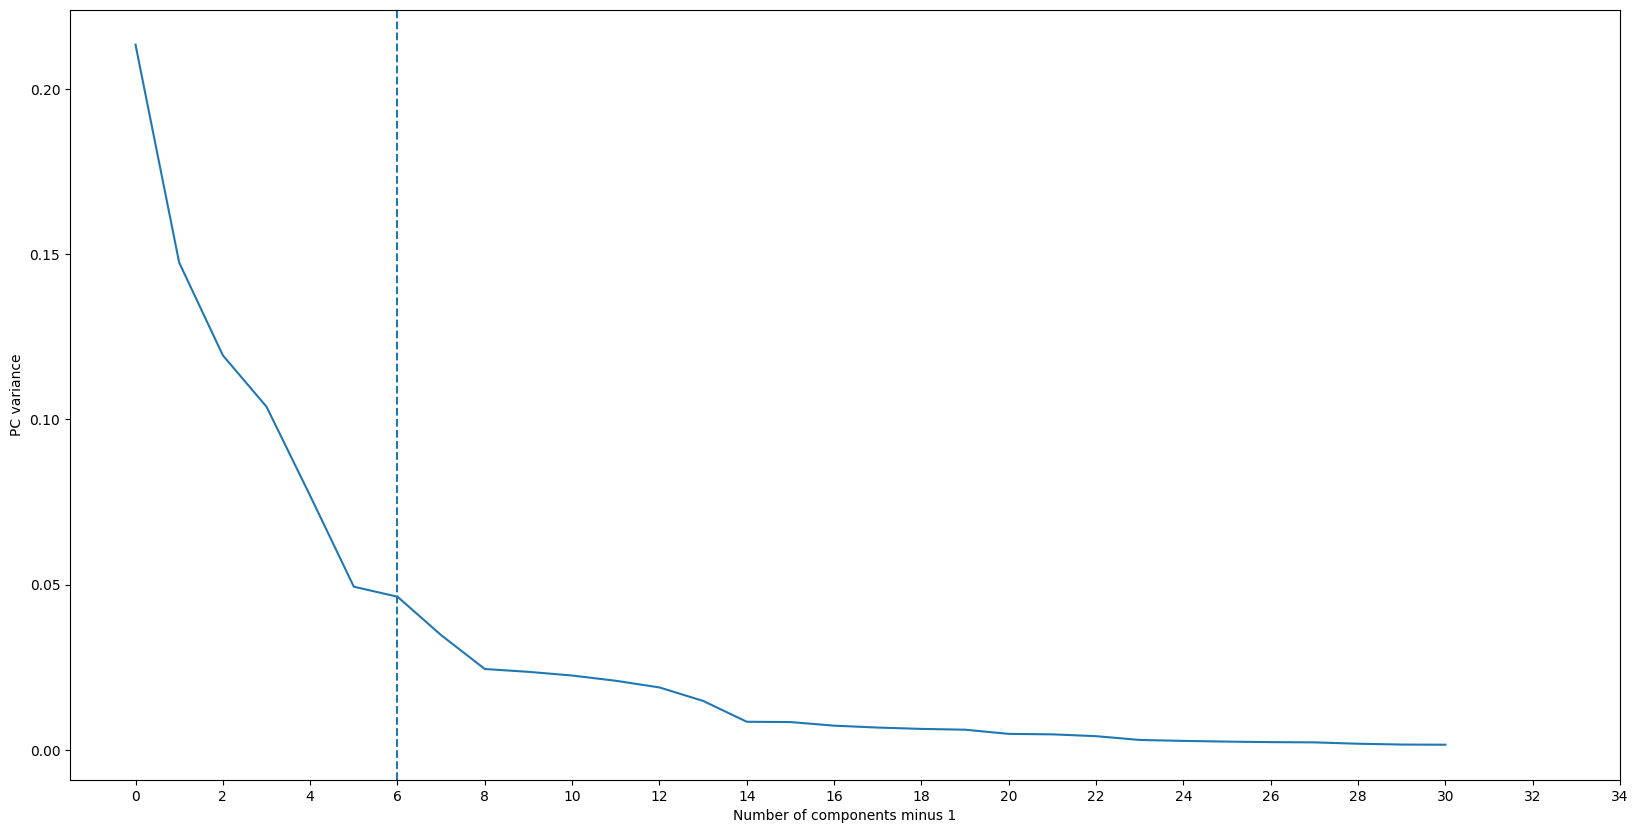

In [269]:
# do a complete PCA and look at the scree and cumulative variance plots
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=6, linestyle='--')

(0.0, 1.0)

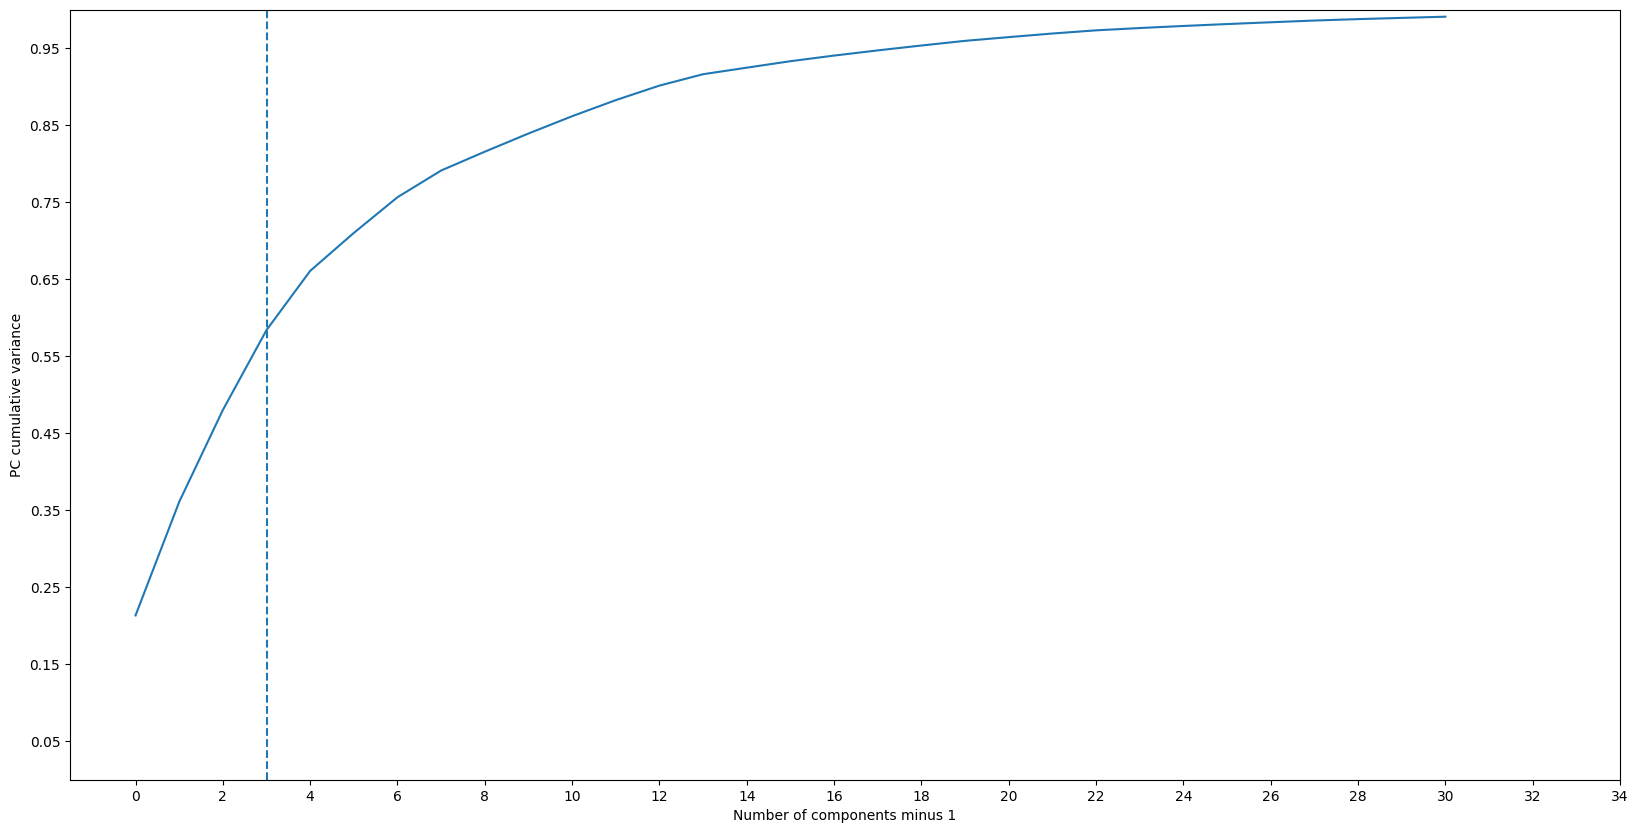

In [270]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=3, linestyle='--')
plt.ylim(0,1)

In [271]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 12.6 s, sys: 876 ms, total: 13.4 s
Wall time: 2.14 s


4

In [272]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.2133432  0.36076766 0.48012732 0.58394139]


In [273]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1044493, 4)

In [274]:
data_pca.head(5)

,PC1,PC2,PC3,PC4
0,-0.293868,0.866511,0.633140,-0.115214
1,-0.300357,1.365950,1.104043,-0.078121
2,-0.314117,2.405358,2.061290,-0.004450
3,-0.282661,0.032445,-0.153859,-0.169897
4,-0.287792,0.403883,0.196843,-0.148305


In [275]:
data_pca.describe()

,PC1,PC2,PC3,PC4
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,4.001651e-16,1.413340e-16,-7.466701e-17,-1.356197e-16
std,3.456475e+00,2.873286e+00,2.585371e+00,2.411138e+00
min,-1.510517e+01,-8.764265e-01,-5.584059e+02,-1.179403e+02
25%,-1.768096e-01,-1.641310e-01,-2.325938e-01,-1.315891e-01
50%,-8.777335e-02,-1.269524e-01,-7.647183e-02,-1.053650e-01
75%,-2.988395e-02,-7.556404e-02,6.766469e-02,-5.217832e-02
max,1.952130e+03,1.989400e+03,1.578892e+03,1.005271e+03


In [276]:
# zscale the pcs to make all the retained PCs equally important.
# do this to make all the retained PCs equally important
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,2.789129e-19,3.102055e-18,1.072114e-17,3.265321e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.370107e+00,-3.050259e-01,-2.159868e+02,-4.891476e+01
25%,-5.115316e-02,-5.712310e-02,-8.996535e-02,-5.457550e-02
50%,-2.539389e-02,-4.418371e-02,-2.957867e-02,-4.369926e-02
75%,-8.645789e-03,-2.629883e-02,2.617214e-02,-2.164053e-02
max,5.647748e+02,6.923782e+02,6.107024e+02,4.169278e+02


In [277]:
data_pca_zs.shape

(1044493, 4)

In [278]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4
0,-0.085019,0.301575,0.244893,-0.047784
1,-0.086897,0.475397,0.427035,-0.032400
2,-0.090878,0.837145,0.797290,-0.001846
3,-0.081777,0.011292,-0.059512,-0.070463
4,-0.083262,0.140565,0.076137,-0.061508


## Now calculate two unsupervised fraud scores

In [279]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Good choices are anywhere from 1 to about 4.
p1 = 2
p2 = 2
ntop = 1000

### Calculate score 1

In [280]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0    0.400539
1    0.645725
2    1.159632
3    0.123781
4    0.190450
5    0.176590
6    0.933790
7    0.904465
8    0.904465
9    0.904465
dtype: float64

In [281]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4
0,-0.085019,0.301575,0.244893,-0.047784
1,-0.086897,0.475397,0.427035,-0.032400
2,-0.090878,0.837145,0.797290,-0.001846
3,-0.081777,0.011292,-0.059512,-0.070463
4,-0.083262,0.140565,0.076137,-0.061508
5,-0.083123,0.128044,0.063010,-0.062520
6,-0.089059,0.676296,0.637533,-0.014399
7,-0.088840,0.655915,0.616179,-0.016231
8,-0.088840,0.655915,0.616179,-0.016231
9,-0.088840,0.655915,0.616179,-0.016231


In [282]:
score1.max()

725.6335409973061

### Autoencoder for score 2

In [283]:
%%time
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: user 18.6 s, sys: 89.8 ms, total: 18.7 s
Wall time: 18.7 s


/Users/shaggy/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [284]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [285]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,0.400539,0.106112,9
1,0.645725,0.207066,10
2,1.159632,0.411705,11
3,0.123781,0.081817,12
4,0.190450,0.034974,13
5,0.176590,0.035030,14
6,0.933790,0.325206,15
7,0.904465,0.313225,16
8,0.904465,0.313225,17
9,0.904465,0.313225,18


In [286]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,0.400539,0.106112,9,970724.0,750298.0
1,0.645725,0.207066,10,998565.0,958874.0
2,1.159632,0.411705,11,1022236.0,1004541.0
3,0.123781,0.081817,12,665076.0,696793.0
4,0.190450,0.034974,13,815448.0,332249.0
5,0.176590,0.035030,14,774480.0,333166.0
6,0.933790,0.325206,15,1014565.0,993302.0
7,0.904465,0.313225,16,1013361.0,991243.0
8,0.904465,0.313225,17,1013358.0,991246.0
9,0.904465,0.313225,18,1013360.0,991244.0


In [287]:
# calculate the final score as the average of the two scores
# Could do other possible combinations of these
# Could do different weightings, or a max or min
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores_sorted.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
897398,725.633541,696.124310,917942,1044493.0,1044493.0,1044493.0
1040913,638.546816,616.786517,1067360,1044492.0,1044492.0,1044492.0
110100,565.764235,540.352530,111420,1044491.0,1044491.0,1044491.0
934505,525.283790,500.581446,956520,1044490.0,1044490.0,1044490.0
641107,412.042949,387.635286,658933,1044488.0,1044489.0,1044488.5
973751,418.350476,385.508858,996722,1044489.0,1044488.0,1044488.5
632014,359.095629,326.263593,649717,1044487.0,1044486.0,1044486.5
757611,355.297265,332.941681,776306,1044486.0,1044487.0,1044486.5
544656,328.184432,299.830367,561383,1044485.0,1044485.0,1044485.0
219652,305.527123,285.293222,230596,1044484.0,1044484.0,1044484.0


In [288]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
299472,0.044866,0.005917,311878,181.0,3.0,92.0
919572,0.043185,0.007260,941416,101.0,33.0,67.0
304227,0.041940,0.007182,316787,49.0,31.0,40.0
297532,0.041184,0.007153,309882,40.0,29.0,34.5
298733,0.041604,0.006020,311115,44.0,4.0,24.0
299552,0.040494,0.006697,311960,30.0,15.0,22.5
299551,0.040433,0.006734,311959,28.0,16.0,22.0
298731,0.039170,0.006297,311113,19.0,9.0,14.0
981811,0.037483,0.005687,1004856,13.0,2.0,7.5
981138,0.037424,0.005121,1004180,12.0,1.0,6.5


In [289]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,2.301185e-01,1.276470e-01,5.368069e+05,5.222470e+05,5.222470e+05,5.222470e+05
std,1.986717e+00,1.692827e+00,3.080025e+05,3.015193e+05,3.015193e+05,2.970887e+05
min,2.749037e-02,5.120792e-03,9.000000e+00,1.000000e+00,1.000000e+00,6.500000e+00
25%,7.611119e-02,3.102903e-02,2.729100e+05,2.611240e+05,2.611240e+05,2.629790e+05
50%,9.639911e-02,4.979545e-02,5.387720e+05,5.222470e+05,5.222470e+05,5.160735e+05
75%,1.811825e-01,1.169203e-01,8.022750e+05,7.833700e+05,7.833700e+05,8.077320e+05
max,7.256335e+02,6.961243e+02,1.070994e+06,1.044493e+06,1.044493e+06,1.044493e+06


In [290]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06,1.044493e+06
mean,2.301185e-01,1.276470e-01,5.368069e+05,5.222470e+05,5.222470e+05,5.222470e+05
std,1.986717e+00,1.692827e+00,3.080025e+05,3.015193e+05,3.015193e+05,2.970887e+05
min,2.749037e-02,5.120792e-03,9.000000e+00,1.000000e+00,1.000000e+00,6.500000e+00
25%,7.611119e-02,3.102903e-02,2.729100e+05,2.611240e+05,2.611240e+05,2.629790e+05
50%,9.639911e-02,4.979545e-02,5.387720e+05,5.222470e+05,5.222470e+05,5.160735e+05
75%,1.811825e-01,1.169203e-01,8.022750e+05,7.833700e+05,7.833700e+05,8.077320e+05
max,7.256335e+02,6.961243e+02,1.070994e+06,1.044493e+06,1.044493e+06,1.044493e+06


In [291]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,725.633541,696.124310,1044493.0,1044493.0,1044493.0
1067360,638.546816,616.786517,1044492.0,1044492.0,1044492.0
111420,565.764235,540.352530,1044491.0,1044491.0,1044491.0
956520,525.283790,500.581446,1044490.0,1044490.0,1044490.0
658933,412.042949,387.635286,1044488.0,1044489.0,1044488.5
996722,418.350476,385.508858,1044489.0,1044488.0,1044488.5
649717,359.095629,326.263593,1044487.0,1044486.0,1044486.5
776306,355.297265,332.941681,1044486.0,1044487.0,1044486.5
561383,328.184432,299.830367,1044485.0,1044485.0,1044485.0


(0.1, 2083898.7985861353)

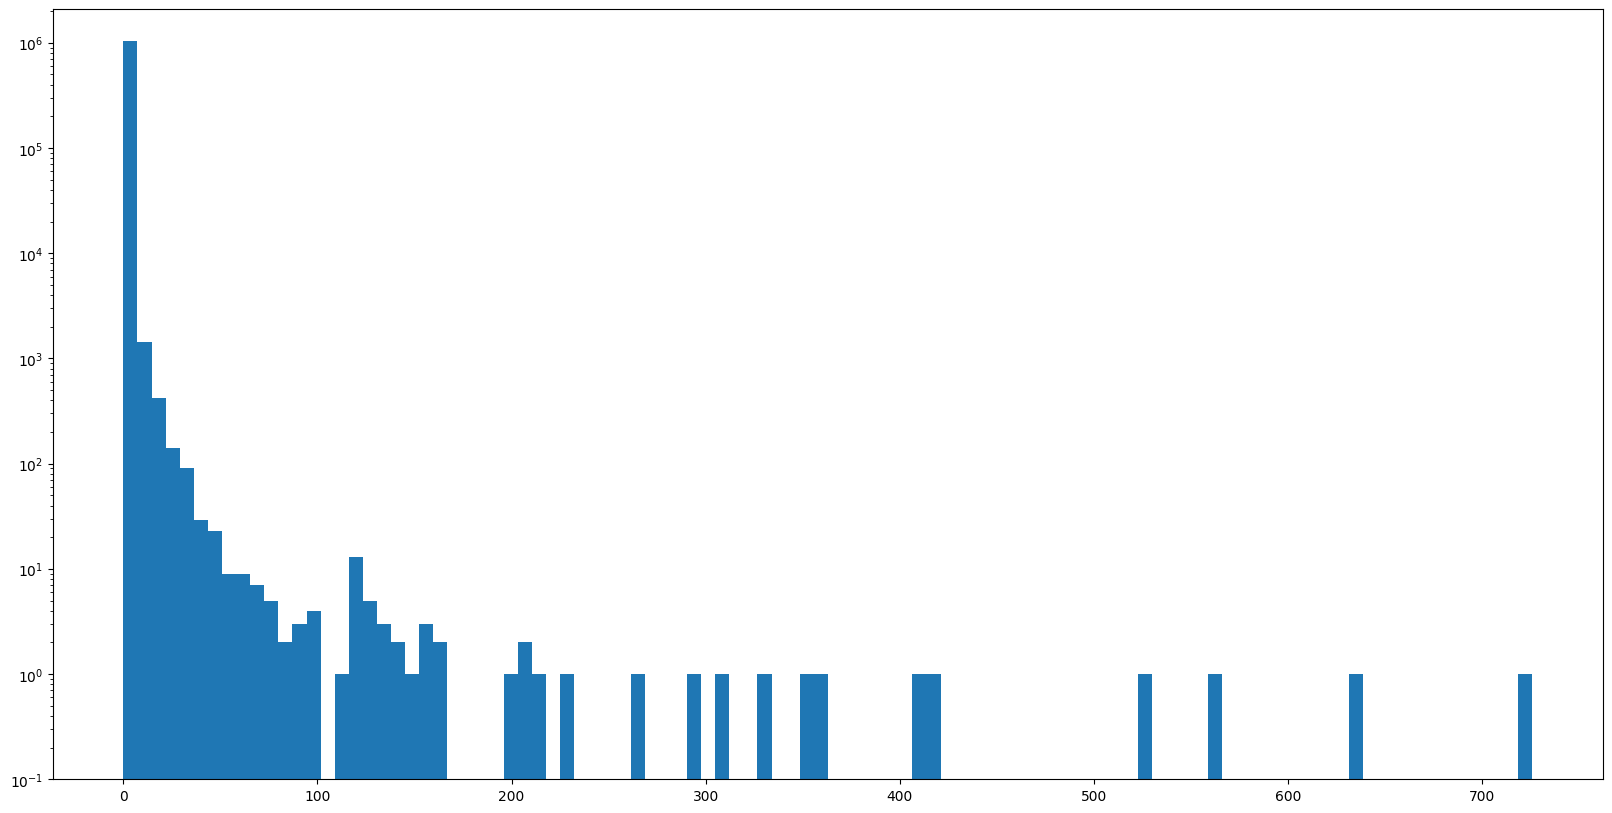

In [292]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [293]:
sc2max = int(score2.max())
sc2max

696

696


(0.1, 2087297.8042741844)

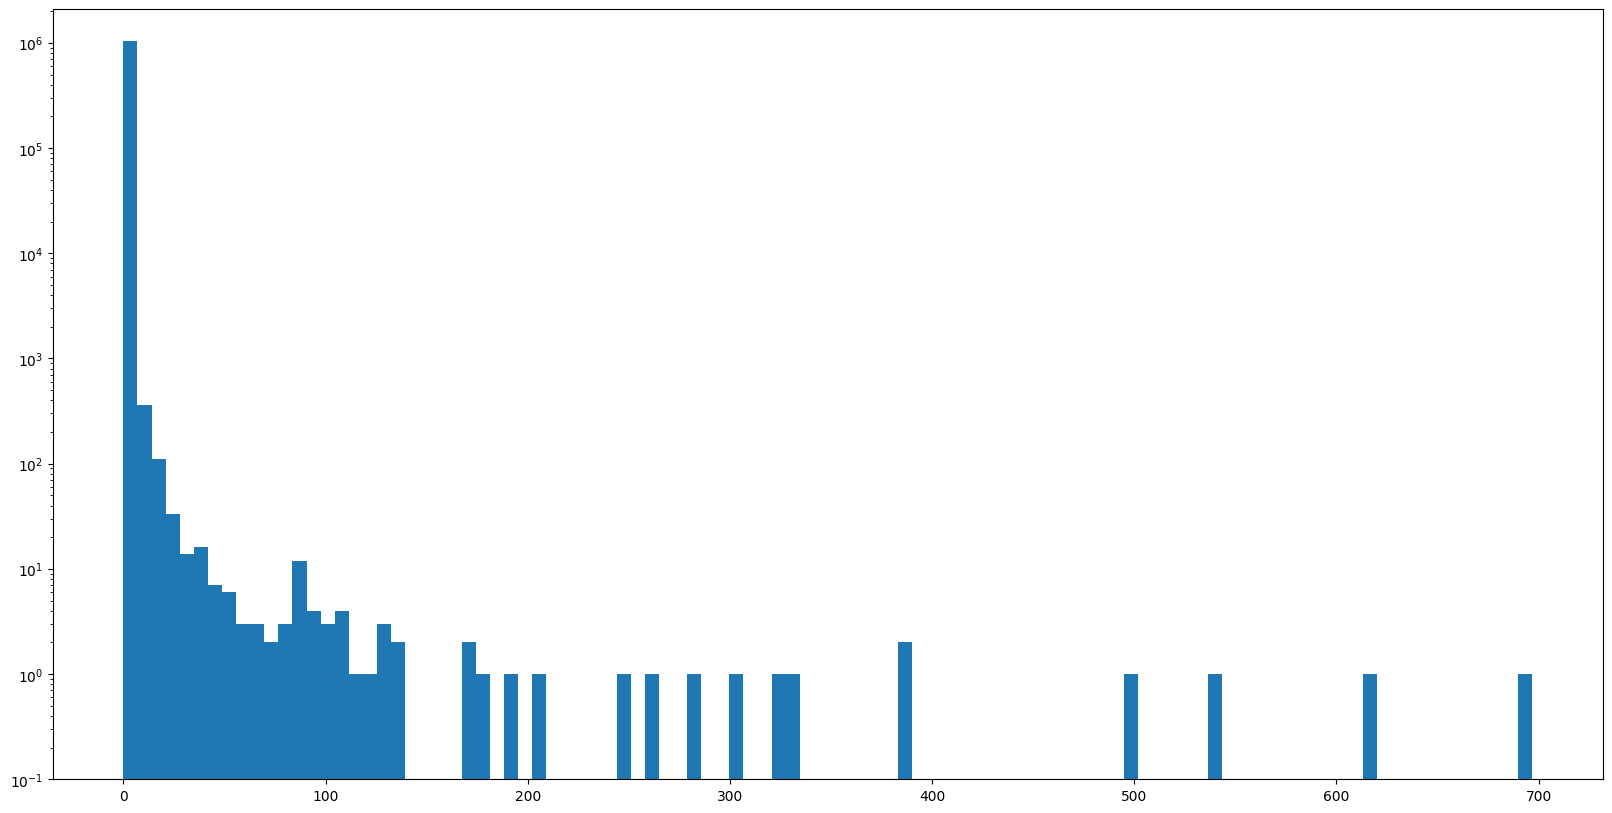

In [294]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

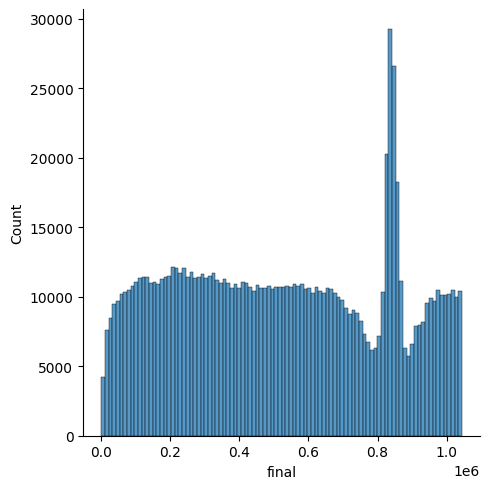

In [295]:
sns.displot(scores['final'])

In [296]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Int64Index([ 917942, 1067360,  111420,  956520,  658933,  996722,  649717,
             776306,  561383,  230596,
            ...
             458986,   40798,  621626,  980497,  830779,   91922,   44335,
             549070,   18539,  334117],
           dtype='int64', name='RECORD', length=1000)


In [297]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
9,0.248600,1.318131,0.197127,0.655554,0.347181,0.024616,1.028691,0.365907,0.026606,-0.021247,...,-0.039017,-0.032765,-0.129517,-0.051905,-0.048662,-0.087588,-0.045224,-0.043105,0.263333,-0.029621
10,0.447488,1.918210,0.298365,0.991419,0.504817,0.037225,1.548244,0.532350,0.040070,-0.021377,...,-0.039017,-0.032765,-0.129612,-0.051905,-0.048662,-0.087711,-0.045224,-0.043105,0.263333,-0.029621
11,1.002314,3.592211,0.580780,1.048614,0.531661,0.039372,2.997607,0.996664,0.077629,-0.021512,...,-0.039017,-0.032765,-0.129622,-0.051905,-0.048662,-0.087838,-0.045224,-0.043105,0.212785,-0.029621
12,-0.083547,0.315988,0.028059,0.094655,0.083927,0.003560,0.161028,0.087945,0.004122,-0.020024,...,-0.039017,-0.032765,-0.128630,-0.051905,-0.048662,-0.086432,-0.045224,-0.043105,0.263334,-0.029621
13,0.064370,0.762279,0.103351,0.344445,0.201164,0.012937,0.547430,0.211732,0.014135,-0.020951,...,-0.039017,-0.032765,-0.129302,-0.051905,-0.048662,-0.087308,-0.045224,-0.043105,0.263334,-0.029621


In [298]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
9,970724.0,750298.0,860511.00
10,998565.0,958874.0,978719.50
11,1022236.0,1004541.0,1013388.50
12,665076.0,696793.0,680934.50
13,815448.0,332249.0,573848.50
14,774480.0,333166.0,553823.00
15,1014565.0,993302.0,1003933.50
16,1013361.0,991243.0,1002302.00
17,1013358.0,991246.0,1002302.00


In [299]:
scores.tail(30)

,score1 rank,score2 rank,final
RECORD,,,
1070965,703687.0,684181.0,693934.0
1070966,733860.0,690254.0,712057.0
1070967,786168.0,719236.0,752702.0
1070968,902498.0,710763.0,806630.5
1070969,795169.0,715067.0,755118.0
1070970,753210.0,708330.0,730770.0
1070971,782830.0,713131.0,747980.5
1070972,692542.0,659540.0,676041.0
1070973,755934.0,711459.0,733696.5


In [300]:
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores['final'].fillna(1,inplace=True)
NY_data_with_scores

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,725701.0,700866.0,713283.5
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,927572.0,770644.0,849108.0
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,883544.0,723576.0,803560.0
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,722609.0,691470.0,707039.5


In [301]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_zs = NY_data_with_scores.join(data_zs, on='RECORD')
NY_data_scored_zs.set_index('RECORD',inplace=True)
NY_data_scored_zs.head(20)

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,0,...,-0.039017,-0.032765,-0.129517,-0.051905,-0.048662,-0.087588,-0.045224,-0.043105,0.263333,-0.029621


In [302]:
NY_data_scored_zs_sorted = NY_data_scored_zs.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_top_n = NY_data_scored_zs_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,-0.039017,-0.032765,-0.129815,-0.051905,-0.048662,-0.087975,-0.045224,-0.043105,12.040692,-0.029621
1067360,5078530085,5,7853,85,NaN,NaN,B2,1,1,1,...,0.002256,0.000482,-0.129805,-0.011278,-0.012530,-0.087975,-0.009982,-0.010967,-0.110205,66.092759
111420,1015101092,1,1510,1092,NaN,BOXWOOD FLTD PARNTERS,R4,2,75,93,...,485.636243,324.098923,-0.118937,381.912906,64.610321,-0.080857,548.336769,286.942901,0.202632,832.626394
956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,91,...,554.924873,667.053736,-0.052347,397.888433,478.126493,-0.021550,455.229052,574.757745,-0.102717,326.238601
658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,100,...,383.534077,461.775214,-0.080522,356.745285,433.133199,-0.055227,318.483725,411.635066,-0.110012,456.952774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91922,1013220039,1,1322,39,NaN,R. SCOTT ANSEN,S3,2A,21,100,...,-0.039017,-0.032765,-0.128155,-0.051905,-0.048662,-0.081005,-0.045224,-0.043105,0.326318,-0.029621
44335,1008550024,1,855,24,NaN,360 PARK SOUTH DELAWA,O3,4,98,200,...,-0.038890,-0.032634,-0.129805,-0.051850,-0.048602,-0.087964,-0.045076,-0.042931,0.256389,0.052012
549070,3081380225,3,8138,225,NaN,BRIGHTLAND REALTY LLC,E1,4,329,395,...,-0.039017,-0.032765,-0.122970,-0.051905,-0.048662,-0.075150,-0.045224,-0.043105,0.314401,-0.029621


In [303]:
NY_data_top_n['OWNER'].head(40)

RECORD
917942      LOGAN PROPERTY, INC.
1067360                      NaN
111420     BOXWOOD FLTD PARNTERS
956520         TROMPETA RIZALINA
658933           WAN CHIU CHEUNG
996722     IMPERIAL COURT HOMEOW
649717                 57-43 LLC
776306                 TONY CHEN
561383       YILDIZ HOLDING A.S.
230596                       NaN
1053859                      NaN
750816                   M FLAUM
545464      AVENUE K DEVELOPERS,
770594               OH, LAURA E
718883           GARDEN VIEW LTD
995567                       NaN
691986     TITAN SOUNDVIEW POINT
293330      CITY OF NY/PARKS AND
1053832           MARKOW, REGINA
151044                       NaN
398266       STARRETT CITY, INC.
1048475    PARK VILLAGE RESIDENT
139726     BRADHURST EQUITIES, L
116647      MF ASSOCIATES OF NEW
1045012           LINDA VITALONE
694272             TSUI, TIT HOW
1000954    MATIONAL COLLECTORS &
113591                       NaN
982930     FOREST VIEW HOMEOWNER
980276     WOODMONT WEST HOA INC
542

<AxesSubplot: >

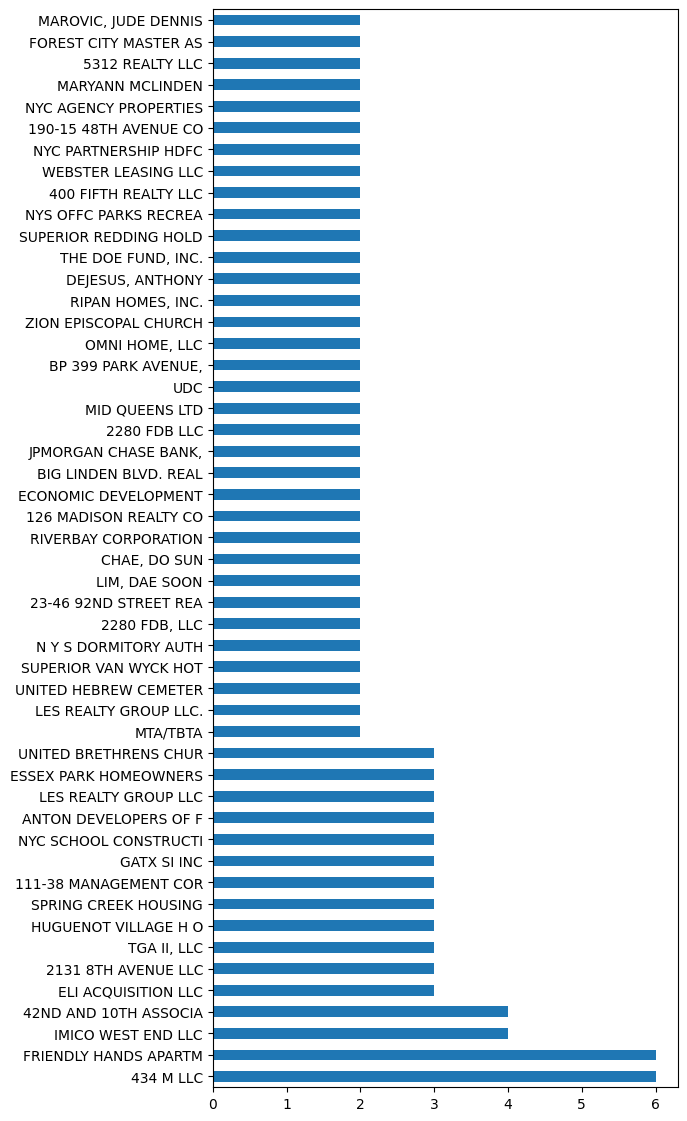

In [304]:
# Can look at this list and add some to the exclusions
plt.figure(figsize=(6,14))
NY_data_top_n['OWNER'].value_counts().head(50).plot(kind='barh')

In [305]:
NY_data_top_n.shape

(1000, 90)

In [306]:
NY_data_top_n.to_excel('NY_top_with_zs.xlsx', index=True)
NY_top_lotsize_ne_0 = NY_data_top_n[NY_data_top_n['LTFRONT'] != 0]
NY_top_lotsize_ne_0.to_excel('NY_top_lotsize_ne_0.xlsx', index=True)

In [307]:
nfields = 34
data_base_vars = NY_data_top_n.iloc[:,nfields:nfields+17]
data_base_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,r2inv,r3inv,r4inv,r5inv,r6inv,r7inv,r8inv
RECORD,,,,,,,,,,,,,,,,,
917942,0.368120,127.772000,274.873071,28.327174,997.972286,1017.734254,40.891099,983.199735,1014.042956,-0.021336,-0.029374,-0.025887,-0.058659,-0.049872,-0.038189,-0.030775,-0.056293
1067360,776.815758,-0.029786,-0.030276,280.231375,-0.006904,-0.003705,270.499521,-0.007961,-0.003636,-0.021669,-0.022232,-0.025143,-0.058670,-0.036301,-0.036543,-0.030783,-0.014454
111420,-0.158634,-0.029786,-0.030276,-0.066920,-0.006904,-0.003705,-0.035122,-0.007961,-0.003636,-0.016898,863.570978,819.445464,-0.047674,571.945958,132.549161,-0.026928,655.788463
956520,-0.055879,-0.029786,-0.030276,-0.032123,-0.006904,-0.003705,-0.088793,-0.007961,-0.003636,-0.020344,95.990447,14.912585,-0.053407,132.877358,21.751006,-0.022752,540.449156
658933,0.090379,-0.029786,-0.030276,0.006026,-0.006904,-0.003705,-0.037850,-0.007961,-0.003636,-0.021016,66.336421,10.315659,-0.055321,119.133980,19.700779,-0.026824,378.103954


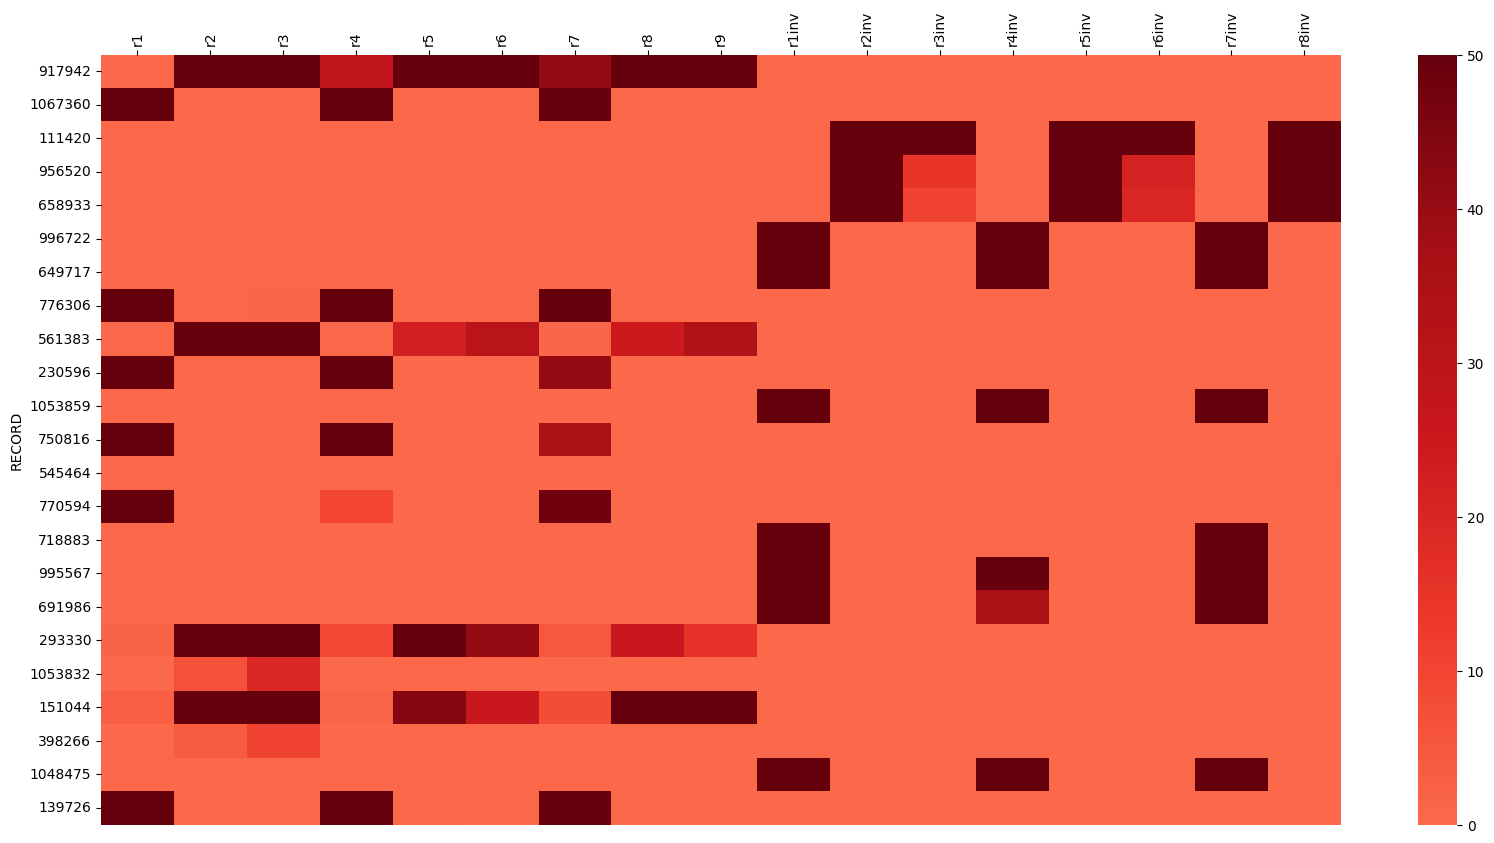

In [308]:
# The heatmaps are good for seeing which variables are driving the high scores
data_heatmap = data_base_vars.abs().head(23)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [309]:
data_all_vars = NY_data_top_n.iloc[:,nfields:]
data_all_vars.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio,size_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,0.368120,127.772000,274.873071,28.327174,997.972286,1017.734254,40.891099,983.199735,1014.042956,-0.021336,...,-0.039017,-0.032765,-0.129815,-0.051905,-0.048662,-0.087975,-0.045224,-0.043105,12.040692,-0.029621
1067360,776.815758,-0.029786,-0.030276,280.231375,-0.006904,-0.003705,270.499521,-0.007961,-0.003636,-0.021669,...,0.002256,0.000482,-0.129805,-0.011278,-0.012530,-0.087975,-0.009982,-0.010967,-0.110205,66.092759
111420,-0.158634,-0.029786,-0.030276,-0.066920,-0.006904,-0.003705,-0.035122,-0.007961,-0.003636,-0.016898,...,485.636243,324.098923,-0.118937,381.912906,64.610321,-0.080857,548.336769,286.942901,0.202632,832.626394
956520,-0.055879,-0.029786,-0.030276,-0.032123,-0.006904,-0.003705,-0.088793,-0.007961,-0.003636,-0.020344,...,554.924873,667.053736,-0.052347,397.888433,478.126493,-0.021550,455.229052,574.757745,-0.102717,326.238601
658933,0.090379,-0.029786,-0.030276,0.006026,-0.006904,-0.003705,-0.037850,-0.007961,-0.003636,-0.021016,...,383.534077,461.775214,-0.080522,356.745285,433.133199,-0.055227,318.483725,411.635066,-0.110012,456.952774


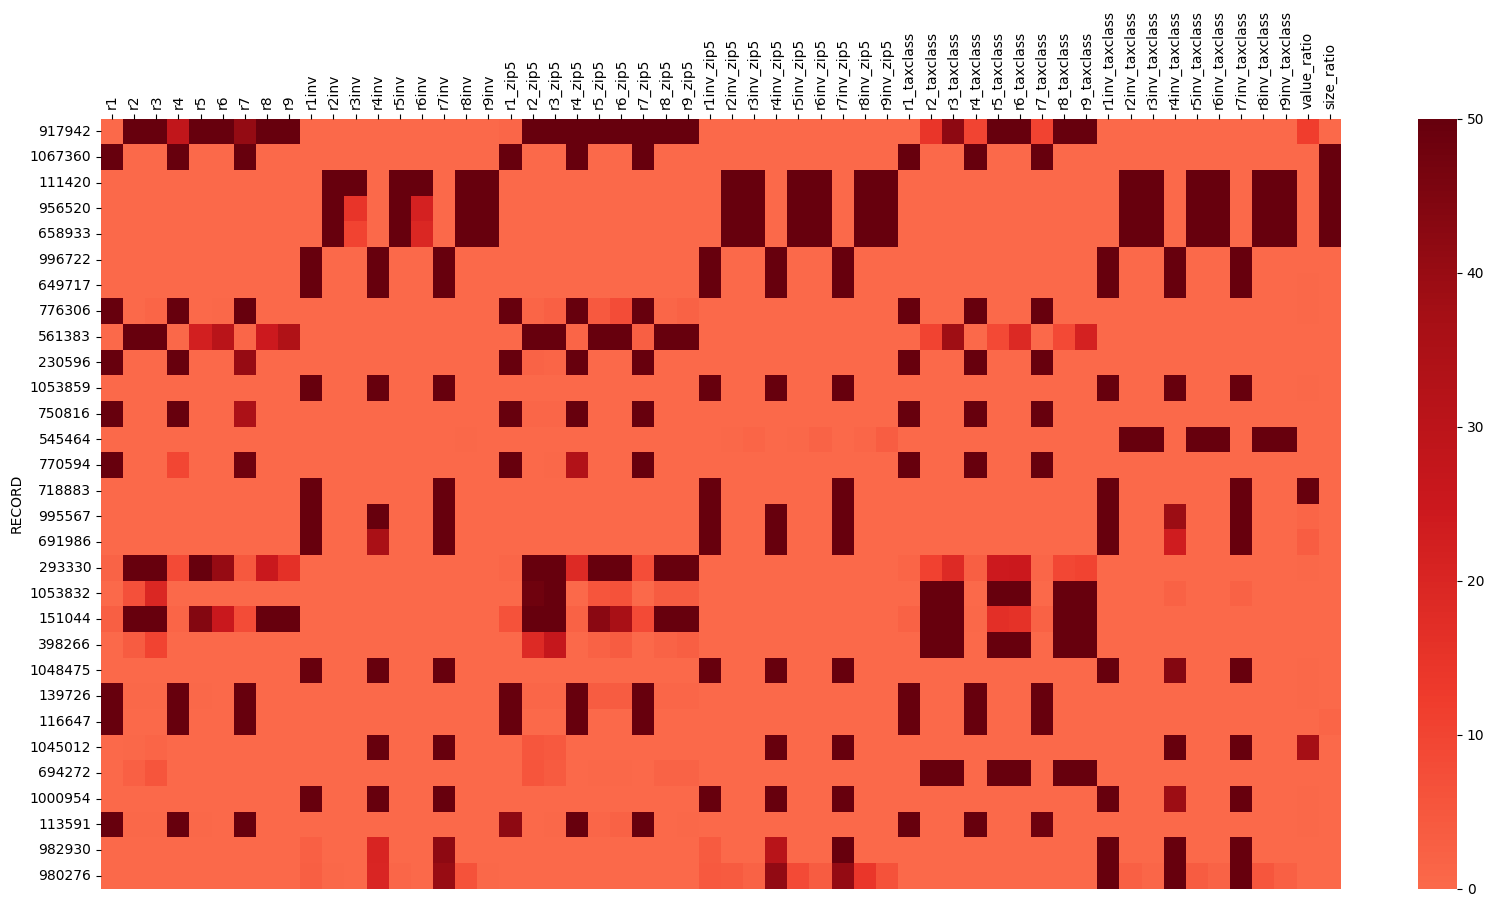

In [310]:
data_heatmap = data_all_vars.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [311]:
top_records_df = pd.DataFrame(top_records)
top_records_df.head(15)

,RECORD
0,917942
1,1067360
2,111420
3,956520
4,658933
5,996722
6,649717
7,776306
8,561383
9,230596


In [321]:
df.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1inv',
       'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv', 'r9inv',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1inv_zip5', 'r2inv_zip5',
       'r3inv_zip5', 'r4inv_zip5', 'r5inv_zip5', 'r6inv_zip5', 'r7inv_zip5',
       'r8inv_zip5', 'r9inv_zip5', 'r1_taxclass', 'r2_taxclass', 'r3_taxclass',
       'r4_taxclass', 'r5_taxclass', 'r6_taxclass', 'r7_taxclass',
       'r8_taxclass', 'r9_taxclass', 'r1inv_taxclass', 'r2inv_taxclass',
       'r3inv_taxclass',

In [322]:
c = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'STADDR', 'ZIP','STORIES','OWNER','EASEMENT','LTFRONT','BLDFRONT','AVLAND','AVTOT']

In [326]:
df[df['RECORD']==750816][c]

,RECORD,BBLE,BORO,BLOCK,LOT,STADDR,ZIP,STORIES,OWNER,EASEMENT,LTFRONT,BLDFRONT,AVLAND,AVTOT
732232,750816,4066610005E,4,6661,5,VLEIGH PLACE,11367.0,4.0,M FLAUM,E,1.0,0,6475.911565,6481.750269


In [323]:
df[df['RECORD']==111420][c]

,RECORD,BBLE,BORO,BLOCK,LOT,STADDR,ZIP,STORIES,OWNER,EASEMENT,LTFRONT,BLDFRONT,AVLAND,AVTOT
110100,111420,1015101092,1,1510,1092,1438 3 AVENUE,10028.0,31.0,BOXWOOD FLTD PARNTERS,NaN,75.0,7575,22896.0,133429.0


In [315]:
df[df['RECORD']==230596][c]

,RECORD,BBLE,BORO,BLOCK,LOT,STADDR,ZIP,STORIES,OWNER,EASEMENT,LTFRONT,BLDFRONT,AVLAND
219652,230596,2049910126,2,4991,126,BELL AVENUE,10466.0,4.0,NaN,NaN,1.0,0,7494.684724


In [316]:
df[df['RECORD']==996722][c]

,RECORD,BBLE,BORO,BLOCK,LOT,STADDR,ZIP,STORIES,OWNER,EASEMENT,LTFRONT,BLDFRONT,AVLAND
973751,996722,5029220125,5,2922,125,OSGOOD AVENUE,10304.0,4.0,IMPERIAL COURT HOMEOW,NaN,300.0,0,1.0


In [317]:
df[df['RECORD']==649717][c]

,RECORD,BBLE,BORO,BLOCK,LOT,STADDR,ZIP,STORIES,OWNER,EASEMENT,LTFRONT,BLDFRONT,AVLAND
632014,649717,4025270002,4,2527,2,57 AVENUE,11378.0,5.502943,57-43 LLC,NaN,51.0,0,10.0


In [ ]:
# Use this cell if you want to write out the top n record numbers
# top_records_df.to_csv('top_n_record_numbers_baseline.csv', index=False)

In [ ]:
# # This cell compares to the previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

# top_records_previous = pd.read_csv('top_n_record_numbers_baseline.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [ ]:
print('Duration: ', datetime.now() - start_time)